In [1]:
import os
import sys
import glob
import random
import warnings
import shutil
from distutils.dir_util import copy_tree


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
from keras.layers import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.metrics import Metric

import skimage.io

In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# IMG_CHANNELS = 3
IMG_CHANNELS = 1

In [3]:
# the small set for experimentation!
TRAIN_PATH = './FORmodels/trainset_raw/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
len(train_ids)

1809

In [4]:
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
Y_train.shape

/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_46066/187304916.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)


(1809, 128, 128)

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    pather = TRAIN_PATH + id_    
    img = imread(pather + '/images/' + id_ + '.png')
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
    pattern = pather+'/masks/*'
    for fname in glob.glob(pattern, recursive=True):

        mask_ = imread(fname)     
        mask_ = resize(mask_,(IMG_HEIGHT, IMG_WIDTH, 1))
#         mask_ = np.expand_dims(mask_, axis=1)        
        mask = np.maximum(mask, mask_)
        
    Y_train[n] = mask

Getting and resizing train images and masks ... 


/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_46066/431872359.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|                                                  | 0/1809 [00:00<?, ?it/s]/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_46066/431872359.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: http

1014 4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64_updown


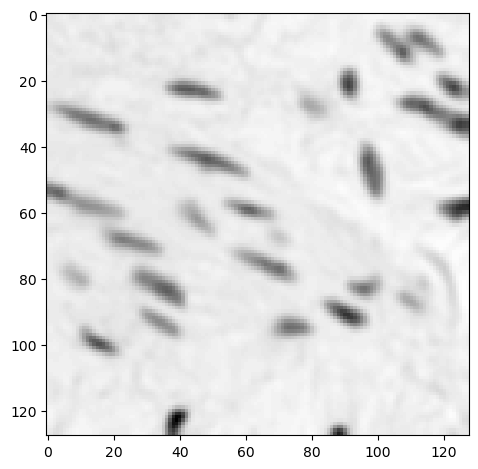

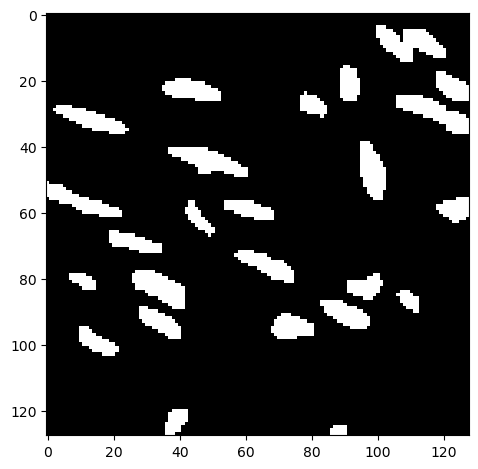

In [6]:
# Check if training data looks all right
# DOUBLE CHECK MASKS!!
ix = random.randint(0, len(train_ids))

print(ix, train_ids[ix])
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# allowing for hyperparam tuning
import keras_tuner as kt
hp = kt.HyperParameters()

In [8]:
def model_builder(hp):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    # here we're using the hyperparam for learning rate!
    model.compile(tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'), amsgrad= True), loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3))

#     model.summary()
    
    return model
    

In [9]:
tuner = kt.RandomSearch(
    model_builder,
    objective = kt.Objective("mean_io_u", direction="max"),
    max_trials=5)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [11]:

# TURNING OFF STOP EARLY
tuner.search(X_train, Y_train, epochs=5, validation_split=0.2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is ... and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is ... and the optimal learning rate for the optimizer
is 0.0008259900546842376.



In [12]:
model = tuner.hypermodel.build(best_hps)

2023-04-02 00:31:49.596067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
## ADDING ADVERSARIAL ATTACK...
loss_object = tf.keras.losses.BinaryCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(np.reshape(input_image, (-1, 128, 128, 1)), dtype=tf.float32)
    input_label = np.reshape(input_label, (-1, 128, 128, 1))

#     Record operations for automatic differentiation??
    with tf.GradientTape() as tape:

        tape.watch(input_image)
        prediction = model(input_image)
        
        loss = loss_object(input_label, prediction)

#   # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [14]:
# Get the input label of the image. -->  THIS NEEDS TO BE A LOOP THROUGH THE IMAGES!!
# WE CAN RANDOMIZE HOW MANY GET A PERTURBATION!!

pert = []

for i in range(len(X_train)):
    pert.append(create_adversarial_pattern(X_train[i],Y_train[i]))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

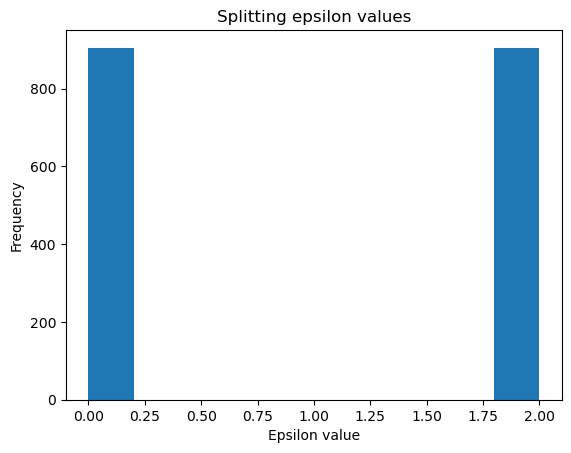

In [15]:
num_ids = list(range(len(X_train)))
none = random.sample(num_ids, int(len(X_train)/2))

newtrain = []
grabbing = []

for i in range(len(X_train)): 
    pert[i] = tf.reshape(pert[i], [1, 128, 128])

    if i in none:
        new = X_train[i] +  0* pert[i] * 0.5 + 0.5
        print(i)
        newtrain.append(np.squeeze(new.numpy()))
        grabbing.append(0)
    else:
        new = X_train[i] +  2* pert[i] * 0.5 + 0.5
        print(i)
        newtrain.append(np.squeeze(new.numpy()))
        grabbing.append(2)
        

plt.hist(grabbing)
plt.title('Splitting epsilon values')
plt.xlabel('Epsilon value')
plt.ylabel('Frequency')
plt.savefig('2(0.5)EpVals_UNet_histo.png')

newtrain = np.asarray(newtrain)
newtrain_2_05 = np.squeeze(newtrain)

In [16]:
newtrain_2_05.shape

(1809, 128, 128)

987


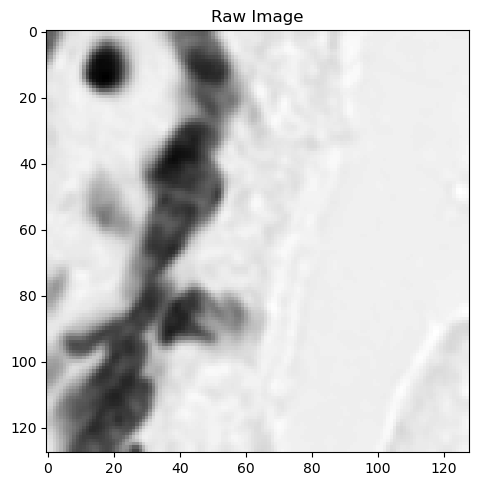

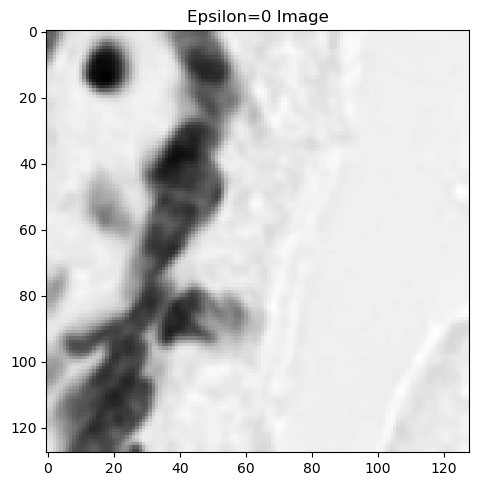

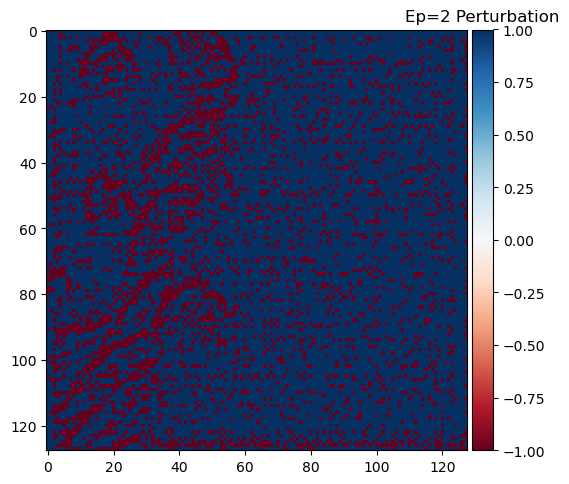

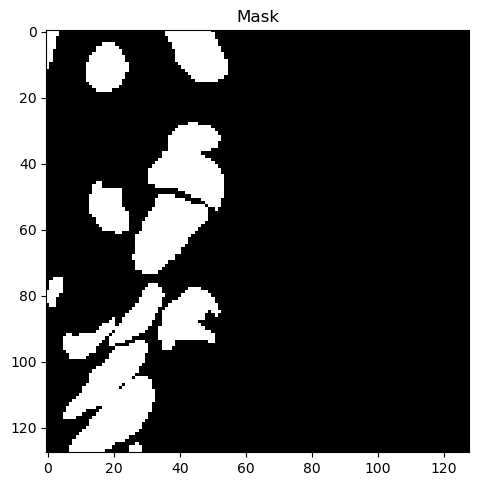

In [20]:
# Let's visualize what we've done here...
# Perform a sanity check on some random training samples
# ix = random.randint(0, len(newtrain_0))
# print(ix)
# imshow(X_train[ix])
# plt.title('Raw Image')
# plt.show()
# imshow(newtrain_0[ix].astype('uint8'))
# plt.title('Epsilon=0 Image')
# plt.show()
# imshow(np.squeeze(pert[ix]))
# plt.title('Ep=2 Perturbation')
# plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.title('Mask')
# plt.show()

In [17]:
# increasing epoch val to 50!!
history = model.fit(newtrain_2_05, Y_train, epochs=50, validation_split=0.2)

Epoch 1/50
46/46 [==============================] - 60s 1s/step - loss: 0.3009 - binary_io_u: 0.5749 - val_loss: 0.1624 - val_binary_io_u: 0.7776
Epoch 2/50
46/46 [==============================] - 59s 1s/step - loss: 0.1457 - binary_io_u: 0.7951 - val_loss: 0.1185 - val_binary_io_u: 0.8293
Epoch 3/50
46/46 [==============================] - 59s 1s/step - loss: 0.1253 - binary_io_u: 0.8215 - val_loss: 0.1040 - val_binary_io_u: 0.8501
Epoch 4/50
46/46 [==============================] - 59s 1s/step - loss: 0.1161 - binary_io_u: 0.8335 - val_loss: 0.1108 - val_binary_io_u: 0.8527
Epoch 5/50
46/46 [==============================] - 60s 1s/step - loss: 0.1086 - binary_io_u: 0.8416 - val_loss: 0.1040 - val_binary_io_u: 0.8573
Epoch 6/50
46/46 [==============================] - 60s 1s/step - loss: 0.1036 - binary_io_u: 0.8480 - val_loss: 0.0947 - val_binary_io_u: 0.8557
Epoch 7/50
46/46 [==============================] - 60s 1s/step - loss: 0.1030 - binary_io_u: 0.8481 - val_loss: 0.0942 - va

In [18]:
val_acc_per_epoch = history.history['val_binary_io_u']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 47


In [19]:
# use the best number of epochs
hypermodel = tuner.hypermodel.build(best_hps)

# FROM = 2023/03/30
# # REMEMBER TO CHANGE THE NAME OF THE MODEL!!
checkpointer = ModelCheckpoint('model-UNetEp=2(0.5)Model_20230330.h5', verbose=1, save_best_only=True)
# Retrain the model--> USE THE NEW_TRAIN
result = hypermodel.fit(newtrain_2_05, Y_train, epochs=best_epoch, validation_split=0.2, callbacks=[checkpointer])


Epoch 1/47
46/46 [==============================] - ETA: 0s - loss: 0.2960 - binary_io_u_1: 0.5679
Epoch 1: val_loss improved from inf to 0.16890, saving model to model-UNetEp=2(0.5)Model_20230330.h5
46/46 [==============================] - 67s 1s/step - loss: 0.2960 - binary_io_u_1: 0.5679 - val_loss: 0.1689 - val_binary_io_u_1: 0.7430
Epoch 2/47
46/46 [==============================] - ETA: 0s - loss: 0.1633 - binary_io_u_1: 0.7686
Epoch 2: val_loss improved from 0.16890 to 0.12744, saving model to model-UNetEp=2(0.5)Model_20230330.h5
46/46 [==============================] - 63s 1s/step - loss: 0.1633 - binary_io_u_1: 0.7686 - val_loss: 0.1274 - val_binary_io_u_1: 0.8117
Epoch 3/47
46/46 [==============================] - ETA: 0s - loss: 0.1268 - binary_io_u_1: 0.8196
Epoch 3: val_loss improved from 0.12744 to 0.10491, saving model to model-UNetEp=2(0.5)Model_20230330.h5
46/46 [==============================] - 62s 1s/step - loss: 0.1268 - binary_io_u_1: 0.8196 - val_loss: 0.1049 - v

Epoch 28/47
46/46 [==============================] - ETA: 0s - loss: 0.0882 - binary_io_u_1: 0.8627
Epoch 28: val_loss did not improve from 0.07898
46/46 [==============================] - 60s 1s/step - loss: 0.0882 - binary_io_u_1: 0.8627 - val_loss: 0.0836 - val_binary_io_u_1: 0.8803
Epoch 29/47
46/46 [==============================] - ETA: 0s - loss: 0.0863 - binary_io_u_1: 0.8660
Epoch 29: val_loss improved from 0.07898 to 0.07895, saving model to model-UNetEp=2(0.5)Model_20230330.h5
46/46 [==============================] - 59s 1s/step - loss: 0.0863 - binary_io_u_1: 0.8660 - val_loss: 0.0790 - val_binary_io_u_1: 0.8756
Epoch 30/47
46/46 [==============================] - ETA: 0s - loss: 0.0851 - binary_io_u_1: 0.8663
Epoch 30: val_loss did not improve from 0.07895
46/46 [==============================] - 59s 1s/step - loss: 0.0851 - binary_io_u_1: 0.8663 - val_loss: 0.0803 - val_binary_io_u_1: 0.8716
Epoch 31/47
46/46 [==============================] - ETA: 0s - loss: 0.0851 - bin

In [23]:
# ALTER THE NAMING CONVENTIONS..
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables--> these two need to be diff
    tr_acc = hist.history['binary_io_u_1']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_binary_io_u_1']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Binary IOU')
    plt.xlabel('Epochs')
    plt.ylabel('Binary IOU')
    plt.legend()

    # change the title!!
    plt.suptitle("UNet trained with 2(0.5) Epsilon", fontsize=30)
    plt.tight_layout
    plt.savefig('model-UNetEp=2(0.5)Model_20230330.png')
    plt.show()

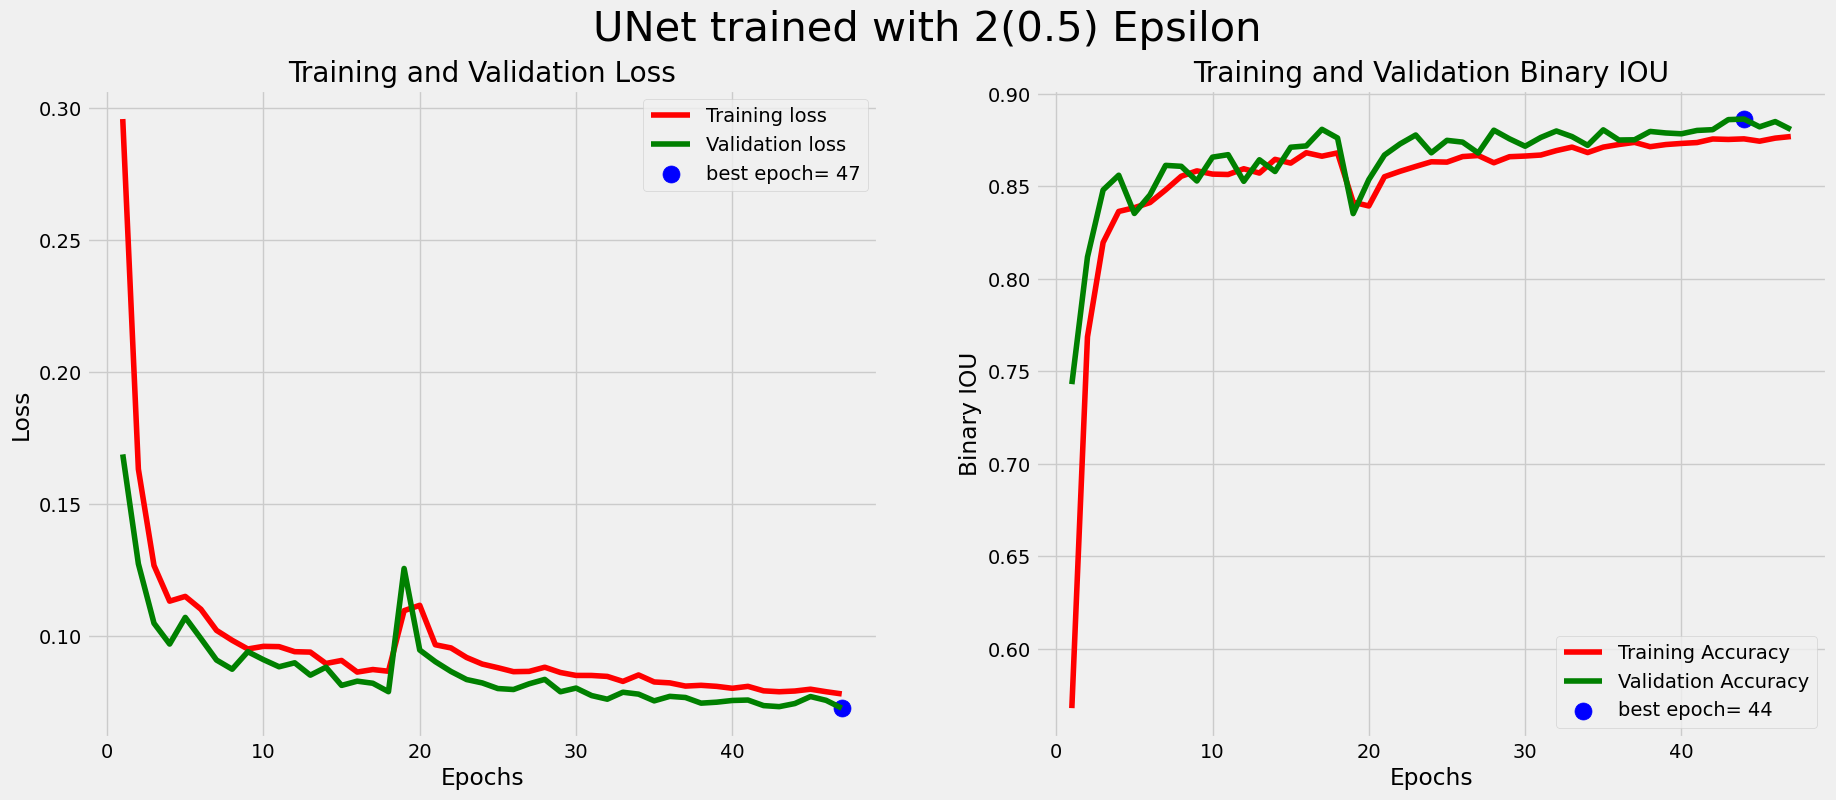

In [25]:
# results.history
plot_training(result)

In [ ]:
# we could stop here...